In [51]:
import os  
import numpy as np
import struct
import matplotlib.pyplot as plt
import gc
import random
from tensorflow import keras

In [52]:
with open("C:\\Users\\Administrator\\source\\data\\dataset.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig1 = np.zeros((NM1,200),dtype = np.float32)
    an1 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an1[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig1[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

In [53]:
with open("C:\\Users\\Administrator\\source\\data\\dataset0.0.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig2 = np.zeros((NM1,200),dtype = np.float32)
    an2 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an2[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig2[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

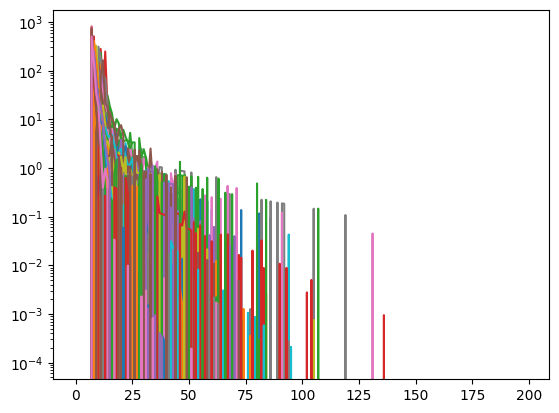

167
[1.4045111e-02 4.7168652e+01 1.1730439e+04 8.5000002e-01]


In [54]:
plt.axes(yscale = "log") 
for n in range(NM1):
    plt.plot(sig2[n])
plt.show()
print(NM1)
print(an1[-1])

In [55]:

def labeling(y,N):
    ##############
    a,b = y.shape
    min0 = np.min(y,0)
    max0 = np.max(y,0)
    step = (max0-min0)/N
    y2 = np.zeros((a,b,N))
    
    # kernel = np.array([1]) 
    # kernel = kernel/np.sum(kernel)
    
    for i in range(a):
        for j in range(b):
            if(step[j]!=0):
                idx = (y[i,j]-min0[j])/step[j]-1
                y2[i,j,int(idx)] = 1
            else:
                y2[i,j,0] = 1
            # y2[i,j] = np.convolve(y2[i,j],kernel,mode='same')
            
    return y2    
  

In [71]:
print(sig1.shape)
print(an1.shape)
print(sig2.shape)
print(an2.shape)
num_labels = 10
x_train = sig1
y_train = an1
x_test = sig2
y_test = an2

x_train = np.log10((x_train+1e-6)/1000)+11
x_test = np.log10((x_test+1e-6)/1000)+11
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
d_train = np.reshape(y_train[:,0],(y_train[:,0].shape[0],1,1)) # add thickness of sample into input data
d_test = np.reshape(y_test[:,0],(y_test[:,0].shape[0],1,1))

x_train = np.concatenate((d_train,x_train),axis = 1) 
x_test = np.concatenate((d_test,x_test),axis = 1)

y_train = labeling(y_train,num_labels)[:,1,:] # select to predict what : 0:thickness 1:mua 2: mus
y_test = labeling(y_test,num_labels)[:,1,:]
print('x_train.shape = '+str(x_train.shape)) 
print('y_train.shape = '+str(y_train.shape)) 

(366, 200)
(366, 4)
(167, 200)
(167, 4)
x_train.shape = (366, 201, 1)
y_train.shape = (366, 10)


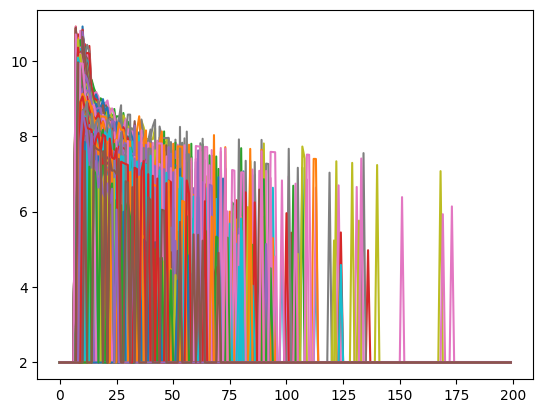

In [72]:
for n in range(x_train.shape[0]):
    plt.plot(x_train[n,1:])
plt.show()


In [73]:
num_classes = y_train.shape[1]
# input_shape = (1,5,1)
# x = np.arange(np.prod(input_shape)).reshape(input_shape)
# print(x)
# y = keras.layers.Cropping1D(cropping=(0,4))(x)
# z = keras.layers.Cropping1D(cropping=(1,0))(x)
# print(y)
# print(z)

In [79]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    d_1 = keras.layers.Cropping1D(cropping=(0,200))(input_layer)
    sig = keras.layers.Cropping1D(cropping=(1,0))(input_layer)
    
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(sig)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    #d_1 = keras.layers.BatchNormalization()(d_1)
    d_1 = keras.layers.Dense(16, activation='relu')(d_1)
    # d_1 = keras.layers.Dense(10, activation='relu')(d_1)
    d_1 = keras.layers.Reshape((16,))(d_1)
    
    d_1 = keras.layers.BatchNormalization()(d_1)
    gap = keras.layers.Dense(16, activation='relu')(gap)
    gap = keras.layers.BatchNormalization()(gap)
    
    merged = keras.layers.Concatenate()([d_1, gap])
    merged = keras.layers.Dense(16, activation='relu')(merged)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(merged)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [80]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
10/10 [==============================] - 2s 56ms/step - loss: 2.3701 - categorical_accuracy: 0.0890 - val_loss: 2.2984 - val_categorical_accuracy: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 25ms/step - loss: 2.2919 - categorical_accuracy: 0.1404 - val_loss: 2.2891 - val_categorical_accuracy: 0.1622
Epoch 3/500
10/10 [==============================] - 0s 19ms/step - loss: 2.2441 - categorical_accuracy: 0.1644 - val_loss: 2.2845 - val_categorical_accuracy: 0.0811
Epoch 4/500
10/10 [==============================] - 0s 29ms/step - loss: 2.2160 - categorical_accuracy: 0.1815 - val_loss: 2.2802 - val_categorical_accuracy: 0.0811
Epoch 5/500
10/10 [==============================] - 0s 18ms/step - loss: 2.1708 - categorical_accuracy: 0.2329 - val_loss: 2.2840 - val_categorical_accuracy: 0.1351
Epoch 6/500
10/10 [==============================] - 0s 18ms/step - loss: 2.1471 - categorical_accuracy: 0.2226 - val_loss: 2.2871 - val_categorical_accuracy: 0.1216


In [81]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

6/6 [==============================] - 0s 13ms/step - loss: 1.2234 - categorical_accuracy: 0.5210
Test accuracy 0.5209580659866333
Test loss 1.2234182357788086


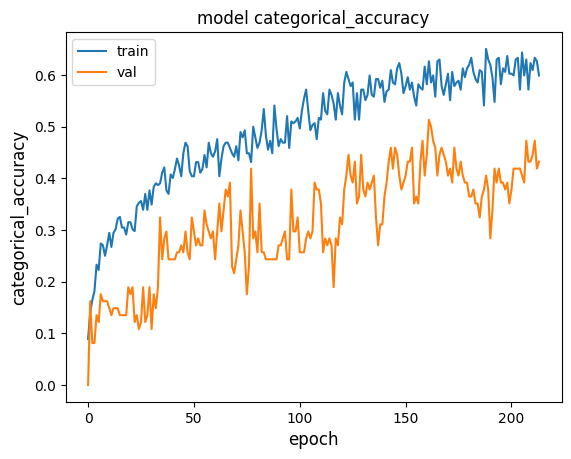

In [82]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
# 你可以用pca或者一些降维方法把特征搞一下